In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    RocCurveDisplay
)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/kaggle/input/welfake-dataset/5. WELFake_Dataset.csv',)
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
data.tail()

,Unnamed: 0,title,text,label
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [6]:
data['text'][0]#lebel 1

'No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to

In [7]:
data['text'][72133]#label 0

'Goldman Sachs Endorses Hillary Clinton For President For Goldman Sachs, was there really any other choice this cycle? | October 27, 2016 Be Sociable, Share! Lloyd Blankfein, CEO of Goldman Sachs, is greeted by Hillary Clinton at a panel discussion at the Clinton Global Initiative, Sept. 24, 2014 in New York. \nPublished in partnership with Shadowproof . \nHe’s with her. On Sunday, former Secretary of State Hillary Clinton earned the endorsement of Goldman Sachs CEO Lloyd Blankfein —an endorsement she had been working toward for years. \nAs was revealed by Wikileaks, Hillary Clinton spent the run up to her presidential campaign giving speeches to Goldman Sachs and other Wall Street banks, where she praised their talents and explained her positions on financial regulation. \nOn October 24, 2013, Clinton told Goldman Sachs that Dodd-Frank had to be done mostly for “political reasons” because Congress needed to look like it was doing something about the crisis. She said, “There’s nothing 

In [8]:
data.drop('Unnamed: 0',axis =1,inplace = True )

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
data.isnull().sum()

title    558
text      39
label      0
dtype: int64

# Handle null value and separate features from labels

In [11]:
data.fillna('',inplace = True)
features = data[['title','text']]
labels = data['label']

In [12]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [13]:
label_status = data['label'].value_counts().reset_index()
label_status.columns = ['label', 'count']


fig = px.pie(label_status,
             values='count',
             names='label',
             hole=0.6,
             title="Spam & Ham Status")

fig.show()


# Create Word clouds

In [14]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

fake_text = ' '.join(data[data['label'] == 0]['text'].astype(str))
real_text = ' '.join(data[data['label'] == 1]['text'].astype(str))

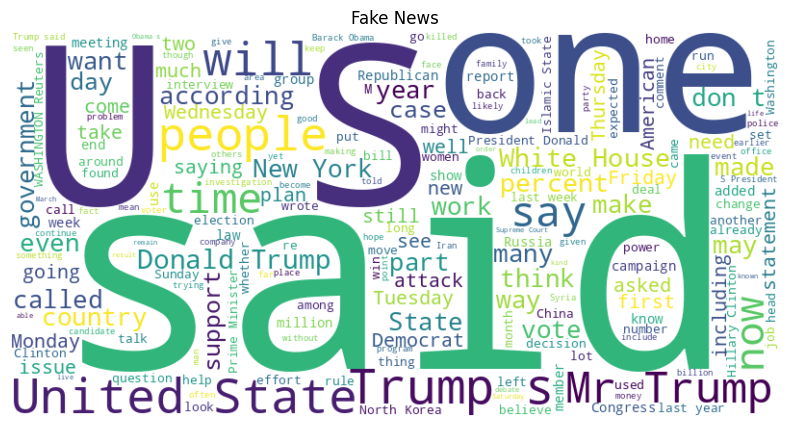

In [15]:
plot_wordcloud(fake_text, 'Fake News')
plt.show()

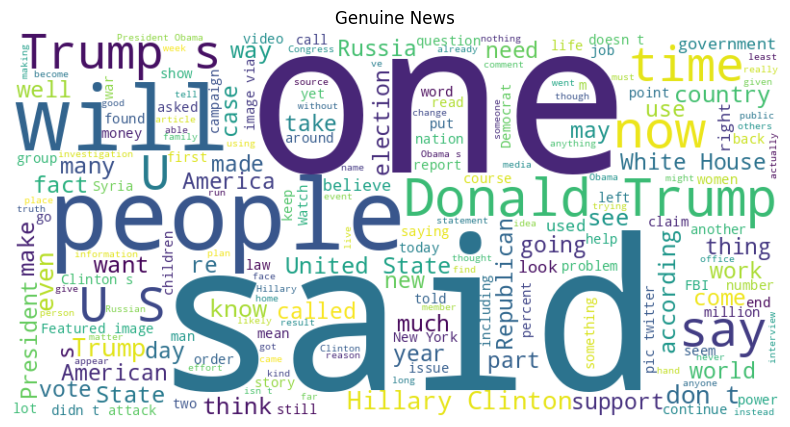

In [16]:
plot_wordcloud(real_text, 'Genuine News')
plt.show()

# Text Prepocessing

In [17]:
text_column = 'text'
label_column = 'label'

In [18]:
stopword = set(stopwords.words('english'))
stopword 

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [19]:
stopwords.fileids()

['albanian',
 'arabic',
 'azerbaijani',
 'basque',
 'belarusian',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'tamil',
 'turkish']

In [20]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
def preprocess_text(text):
    # Remove punctuation
    remove_punc = [char for char in text if char not in string.punctuation]
    clean_words = ''.join(remove_punc)  # Join characters back to text
    
    # Remove stopwords
    filtered_words = [word for word in clean_words.split() if word.lower() not in stopword]
    return ' '.join(filtered_words)

In [22]:
# Apply preprocessing to text column
data[text_column] = data[text_column].astype(str).apply(preprocess_text)


In [23]:
data[text_column] = data[text_column].apply(preprocess_text)

In [24]:
data[text_column]

0        comment expected Barack Obama Members FYF911 F...
1                               post votes Hillary already
2        demonstrators gathered last night exercising c...
3        dozen politically active pastors came private ...
4        RS28 Sarmat missile dubbed Satan 2 replace SS1...
                               ...                        
72129    WASHINGTON Reuters Hackers believed working Ru...
72130    know fantasyland Republicans never questioned ...
72131    Migrants Refuse Leave Train Refugee Camp Hunga...
72132    MEXICO CITY Reuters Donald Trump’s combative s...
72133    Goldman Sachs Endorses Hillary Clinton Preside...
Name: text, Length: 72134, dtype: object

# Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized_text

data[text_column] = data[text_column].apply(lemmatize_text)

In [26]:
data[text_column]

0        comment expected Barack Obama Members FYF911 F...
1                                post vote Hillary already
2        demonstrator gathered last night exercising co...
3        dozen politically active pastor came private d...
4        RS28 Sarmat missile dubbed Satan 2 replace SS1...
                               ...                        
72129    WASHINGTON Reuters Hackers believed working Ru...
72130    know fantasyland Republicans never questioned ...
72131    Migrants Refuse Leave Train Refugee Camp Hunga...
72132    MEXICO CITY Reuters Donald Trump’s combative s...
72133    Goldman Sachs Endorses Hillary Clinton Preside...
Name: text, Length: 72134, dtype: object

In [27]:
#TF-IDF Vectorization

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(data[text_column])
y = data[label_column]

In [28]:
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14808182 stored elements and shape (72134, 363127)>

In [29]:
xtrain,xtest,ytrain,ytest = train_test_split(x,labels,test_size = 0.3,random_state=42)

In [30]:
#nalve bayes models

def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    
    prob = model.predict_proba(xtest)[:, 1]
    
    roc_auc = roc_auc_score(ytest, prob)
    
    fpr, tpr, thresholds = roc_curve(ytest, prob)
    precision, recall, _ = precision_recall_curve(ytest, prob)
    pr_auc = auc(recall, precision)
    
    return {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
    }


In [31]:
mnb_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
mnb_model.fit (xtrain, ytrain)

MultinomialNB()

In [32]:
MultinomialNB()

MultinomialNB()

In [33]:
from sklearn.metrics import precision_recall_curve,auc

nb_results = evaluate_model(mnb_model, xtest, ytest)
nb_results

{'Accuracy': 0.8766692851531814,
 'Confusion Matrix': array([[9713,  900],
        [1769, 9259]])}

In [34]:
#Evaluate manually
cm = confusion_matrix(ytest, mnb_model.predict(xtest))
cm

array([[9713,  900],
       [1769, 9259]])

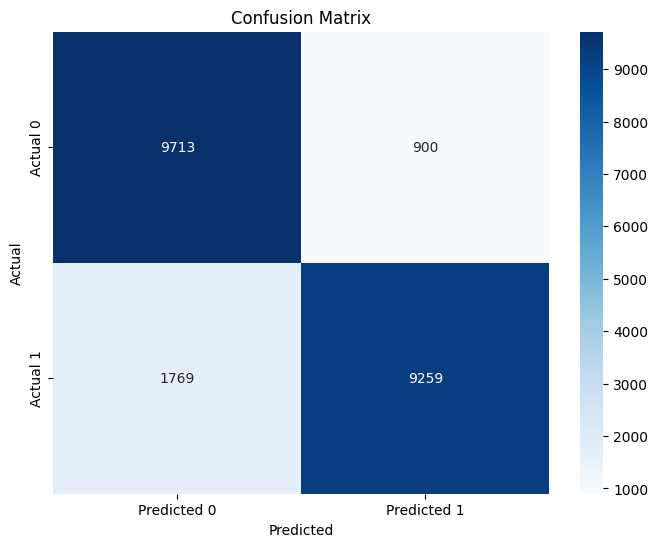

In [35]:
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
print(classification_report(ytest,mnb_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     10613
           1       0.91      0.84      0.87     11028

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



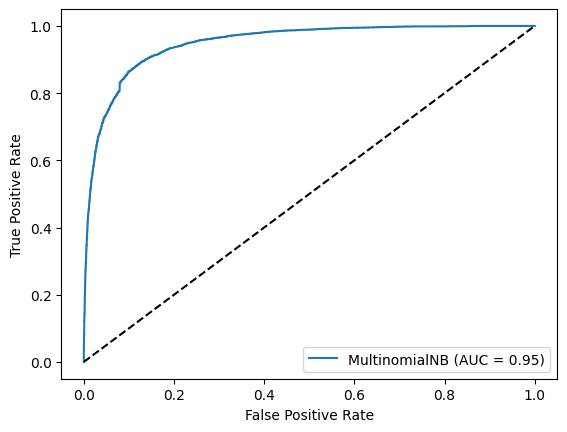

In [37]:
# ROC Curve Plot
RocCurveDisplay.from_estimator(mnb_model, xtest, ytest)
plt.plot([0, 1], [0, 1], 'k--')  # baseline diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Bernoulli Naive Bayes

In [38]:
bnb_model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bnb_model.fit(xtrain, ytrain)

BernoulliNB()

In [39]:
bnb_results = evaluate_model(bnb_model, xtest, ytest)
bnb_results

{'Accuracy': 0.8547664156000185,
 'Confusion Matrix': array([[8575, 2038],
        [1105, 9923]])}

In [40]:
cm_bnb = confusion_matrix(ytest, bnb_model.predict(xtest))
cm_bnb

array([[8575, 2038],
       [1105, 9923]])

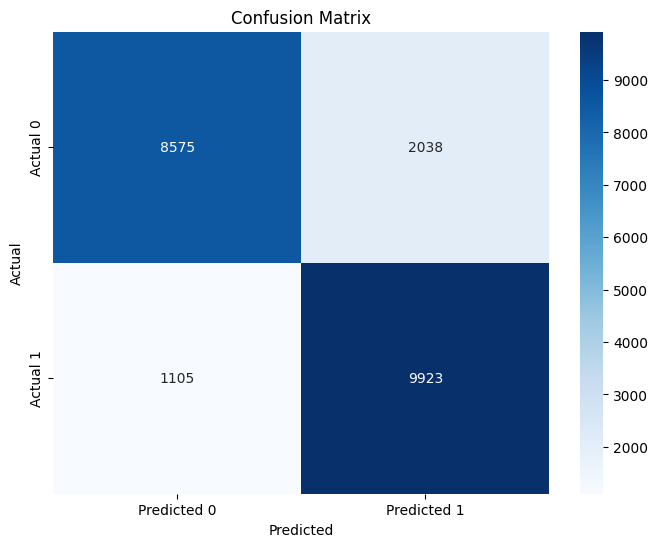

In [41]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
print(classification_report(ytest, bnb_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     10613
           1       0.83      0.90      0.86     11028

    accuracy                           0.85     21641
   macro avg       0.86      0.85      0.85     21641
weighted avg       0.86      0.85      0.85     21641



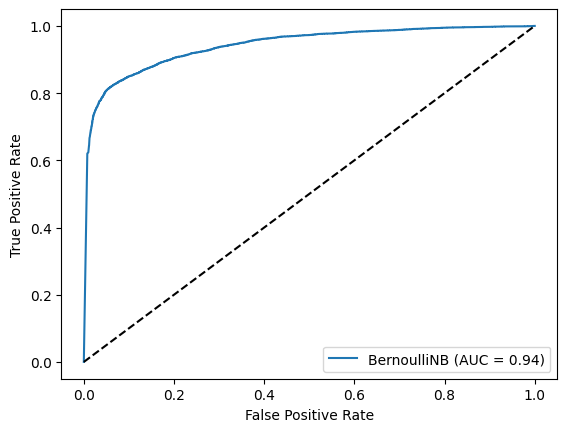

In [43]:


# ROC Curve Plot
RocCurveDisplay.from_estimator(bnb_model, xtest, ytest)
plt.plot([0, 1], [0, 1], 'k--')  # baseline diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


# Logistic Regression

In [44]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(xtrain, ytrain)

LogisticRegression(max_iter=1000)

In [45]:
#Evaluate Logistic Regression

lr_results = evaluate_model(lr_model, xtest, ytest)
lr_results

{'Accuracy': 0.9511575250681576,
 'Confusion Matrix': array([[ 9974,   639],
        [  418, 10610]])}

In [46]:
cm_lr = confusion_matrix(ytest, lr_model.predict(xtest))
cm_lr

array([[ 9974,   639],
       [  418, 10610]])

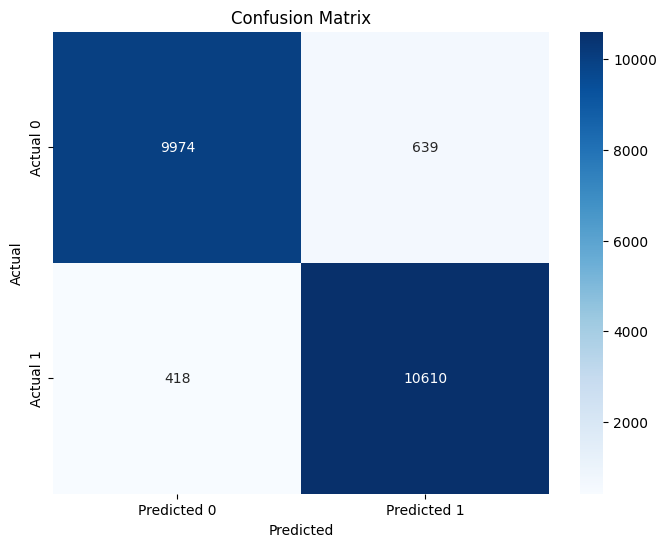

In [47]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

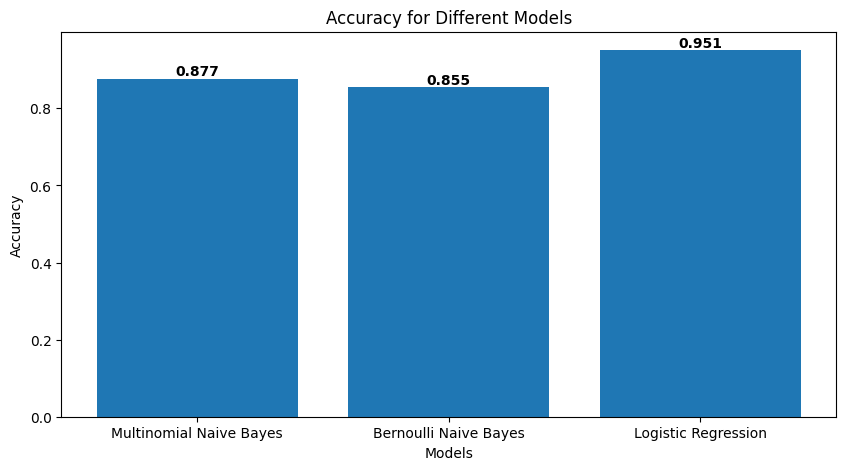

In [48]:
def plot_histogram(metric_values, model_names, metric_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = plt.bar(model_names, metric_values)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

    plt.show()

accuracy_values = [nb_results['Accuracy'], bnb_results['Accuracy'], lr_results['Accuracy']]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression']
plot_histogram(accuracy_values, model_names, 'Accuracy')

In [49]:
models = [mnb_model, bnb_model, lr_model]

In [55]:
random_text = input()

preprocessed_text = preprocess_text(random_text) # remove punctuation 
lemmatized_text = lemmatize_text(preprocessed_text) # text scaling
text_vector = vectorizer.transform([lemmatized_text])

 No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to

In [ ]:
preprocessed_text

In [56]:
lemmatized_text

'comment expected Barack Obama Members FYF911 FukYoFlag BlackLivesMatter movement called lynching hanging white people cop encouraged others radio show Tuesday night turn tide kill white people cop send message killing black people AmericaOne FYoFlag organizer called Sunshine radio blog show hosted Texas called Sunshine Fing Opinion Radio Show snapshot FYF911 LOLatWhiteFear Twitter page 953 pm show urging supporter Call fyf911 tonight continue dismantle illusion white SNAPSHOT Twitter Radio Call Invite FYF911The radio show aired 1000 pm eastern standard timeDuring show caller clearly call lynching killing white peopleA 239 minute clip radio show heard provided Breitbart Texas someone would like referred Hannibal already received death threat result interrupting FYF911 conference callsAn unidentified black man said mother fkers start fing Like u bunch niers takin one u roll said Cause already roll gang anyway six seven black mother fckers see white person lynch as Let turn table conspir

In [57]:
text_vector

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 283 stored elements and shape (1, 363127)>

In [58]:
text_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [59]:
for model in models:
    prediction = model.predict(text_vector)
    print(f"Model: {type(model).__name__}")
    print("Prediction:", prediction)
    print('\n')

Model: MultinomialNB
Prediction: [1]


Model: BernoulliNB
Prediction: [1]


Model: LogisticRegression
Prediction: [1]




# Save for Deployment

In [62]:
import pickle

# Define a file path where you want to save the model
model_file_path = 'logistic_regression_model.pkl'

# Save the model to the file
with open(model_file_path, 'wb') as model_file:
    pickle.dump(lr_model, model_file)

In [63]:
with open(model_file_path, 'rb') as model_file:
    loaded_LR = pickle.load(model_file)

In [64]:
loaded_LR.predict(xtest)

array([1, 1, 0, ..., 1, 1, 0])

In [65]:
loaded_LR.score(xtest, ytest)

0.9511575250681576

In [66]:
text_vector

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 283 stored elements and shape (1, 363127)>

In [67]:
loaded_LR.predict(text_vector)

array([1])